# Product bundling analysis: market basket rules for co promotion

## Overarching business question
Given that Premium Loyalists generate roughly 76% of revenue, which high-support product and category bundles within Dunnhumby baskets deserve prioritized co-promotional shelf space and tailored bundles so we simultaneously defend that core segment and expand the ring size of occasional shoppers? 

## Data preparation and loading
Firstly, we need to set up a few basics before performing the analysis. This includes (i) point Python to the project folder so it can find our helper functions, (ii) pull in pandas/numpy/matplotlib for data work and plotting, (iii) load the cleaned basket_level.parquet file, and (iv) make sure an outputs/ folder exists to hold charts. Lastly, we wanted to keep numbers nicely formatted and apply a plotting style so every downstream table and figure looks clean without repeating setup code.

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PROJECT_DIR = Path().resolve()
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

from functions import (
    load_basket_dataset,
    summarize_basket_sizes,
    compute_category_support,
    prepare_basket_matrix,
    generate_rules,
    describe_rule_clusters,
    top_rules_by_consequent,
    plot_basket_size_distribution,
    plot_category_support,
    plot_rule_network,
)

DATA_PATH = PROJECT_DIR / 'data' / 'basket_level.parquet'
OUTPUT_DIR = PROJECT_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
plt.style.use('seaborn-v0_8')

### Data assembly 
Once we have this, we will load and print part of the cleaned transaction file so every number we compute comes from the exact same, tidy dataset ensuring no conflicting extracts.

In [2]:
basket_df = load_basket_dataset(DATA_PATH)
basket_df.head()

,household_key,BASKET_ID,DAY,TXN_DATE,WEEK_NO,STORE_ID,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,BRAND,MANUFACTURER,QUANTITY,SALES_VALUE,NET_SPEND,PRICE_PER_UNIT
0,2375,26984851472,1,2017-01-01,1,364,1004906,PRODUCE,POTATOES,POTATOES RUSSET (BULK&BAG),Private,69,1,1.39,1.99,1.99
1,2375,26984851472,1,2017-01-01,1,364,1033142,PRODUCE,ONIONS,ONIONS SWEET (BULK&BAG),National,2,1,0.82,0.82,0.82
2,2375,26984851472,1,2017-01-01,1,364,1036325,PRODUCE,VEGETABLES - ALL OTHERS,CELERY,Private,69,1,0.99,1.29,1.29
3,2375,26984851472,1,2017-01-01,1,364,1082185,PRODUCE,TROPICAL FRUIT,BANANAS,National,2,1,1.21,1.21,1.21
4,2375,26984851472,1,2017-01-01,1,364,8160430,PRODUCE,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,Private,69,1,1.50,1.89,1.89


### Data exploration
Lastly, we will explore the assembled dataset to summarize its and validate that it covers enough households and time to answer the bundling question.

In [3]:
basket_counts, basket_stats = summarize_basket_sizes(basket_df)
basket_spend = basket_df.groupby('BASKET_ID')['NET_SPEND'].sum()
summary = pd.DataFrame(
    {
        'Metric': [
            'Transactions analyzed',
            'Unique baskets',
            'Unique households',
            'Unique products',
            'Calendar span',
            'Average unique items per basket',
            'Median basket net spend ($)'
        ],
        'Value': [
            f"{len(basket_df):,}",
            f"{basket_df['BASKET_ID'].nunique():,}",
            f"{basket_df['household_key'].nunique():,}",
            f"{basket_df['PRODUCT_ID'].nunique():,}",
            f"{basket_df['TXN_DATE'].min().date()} to {basket_df['TXN_DATE'].max().date()}",
            f"{basket_counts['unique_items'].mean():.1f}",
            f"{basket_spend.median():.2f}"
        ]
    }
)
summary

,Metric,Value
0,Transactions analyzed,"2,580,564"
1,Unique baskets,"275,552"
2,Unique households,"2,500"
3,Unique products,"91,994"
4,Calendar span,2017-01-01 to 2018-12-12
5,Average unique items per basket,9.4
6,Median basket net spend ($),19.98


#### Conclusion:

After this exploration we see that the dataset is suitable for product bundle discovery. We have 2.6 million transaction rows aggregated into 275k baskets across 2,500 households over a two-year window, so rule mining won’t suffer from thin samples or seasonal gaps. Nearly 92k products give enough variety to surface meaningful cross-category pairs, yet the average shopper still buys about 9 distinct items and spends ~$20 per trip, which matches the compact bundle sizes we intend to test. Taken together, the scale, diversity, and realistic basket depth confirm that this data is fit for identifying product bundles that can be promoted in-store.

## Basket size check 
Before conducting the association rules, we will check the average basket size of Premium loyalists, which will help us to understand how many different products they actually buy on a trip. Hence, we inspect the distribution to make sure our marketing plays stay within real world limits. This number will set the ceiling for any bundle we propose. If Premium Loyalists usually walk out with around nine unique items, a bundle that asks them to buy six or seven complementary products still feels natural; anything larger would clash with their normal behavior and likely underperform. So, measuring basket size upfront tells us the realistic bundle footprint before we start mining rules.

### Intermediate business question
How many unique items do our target shoppers (especially Premium Loyalists) typically place in a single basket?


,value
count,"275,552.00"
mean,9.37
std,12.24
min,1.00
50%,5.00
75%,12.00
90%,24.00
95%,35.00
max,168.00


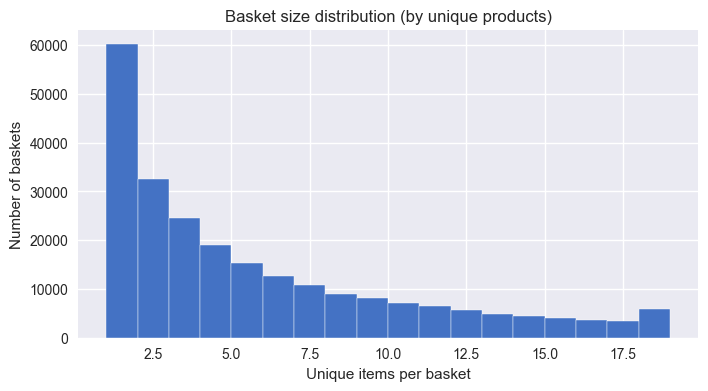

In [4]:
basket_plot_path = OUTPUT_DIR / 'basket_size_distribution.png'
ax = plot_basket_size_distribution(basket_counts, output_path=str(basket_plot_path))
basket_stats.to_frame(name='value')

#### Takeaway: 
Most premium loyalties buy between 3 and 9 unique items per basket, with only the top 10% exceeding 24 items. However, as we want our bundles to remain consistent with real customer behavior and give room for additional products outside the bundles to be included in our customers baskets, we have concluded that we will create bundles of 3 products. This fills a meaningful share of the basket while still leaving plenty of space for shoppers to add the rest of their list outside the promoted bundle.

## Anchor categories 
We looked at anchor categories (category-level support) to make sure every bundle starts with products shoppers already pick up all the time, those anchors decide whether a promo feels relevant to most of our loyalists.

In order to do this we used the support metric, which is a simple association-metric: percentage of all baskets that contain a given item or category. For instance, if a category has 20% support, that means 1 out of every 5 baskets includes it. We use support to spot reliable anchors because high-support items show up often enough that promoting them will resonate with a big chunk of shoppers.

### Intermediate business question

Which categories show up in enough baskets to serve as reliable anchors for bundle promotions that reach the majority of our shoppers?

In [5]:
category_support = compute_category_support(basket_df, level='COMMODITY_DESC', top_n=15)
category_support

,COMMODITY_DESC,support,support_pct
0,SOFT DRINKS,0.26,25.96
1,FLUID MILK PRODUCTS,0.25,25.11
2,BAKED BREAD/BUNS/ROLLS,0.22,21.87
3,CHEESE,0.17,17.00
4,BAG SNACKS,0.15,15.23
5,BEEF,0.13,13.32
6,TROPICAL FRUIT,0.12,11.78
7,EGGS,0.10,10.11
8,COUPON/MISC ITEMS,0.10,10.01
9,REFRGRATD JUICES/DRNKS,0.09,9.41


<Axes: title={'center': 'Top categories by basket penetration'}, xlabel='Share of baskets (%)', ylabel='Commodity Desc'>

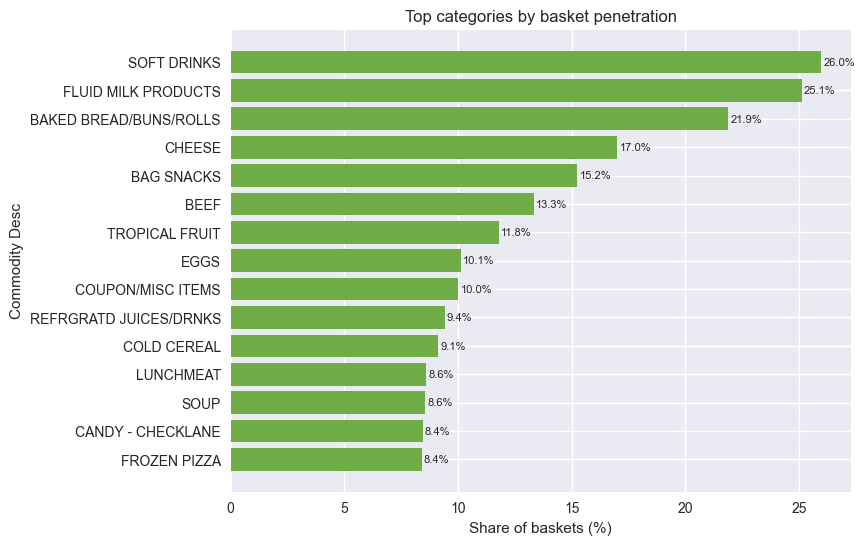

In [6]:
category_plot_path = OUTPUT_DIR / 'category_support.png'
plot_category_support(category_support, output_path=str(category_plot_path))

#### Takeaway:
Soft drinks, fluid milk, and bakery bread each land in roughly a quarter of all baskets, so they’re our safest anchors when we want a bundle that touches most shoppers. Cheese and bagged snacks still clear 15% penetration, making them strong co-stars for snack or meal bundles, while beef and tropical fruit (12–13%) give us meat and produce anchors without dropping into niche territory. Even the lower entries on the chart—cold cereal, lunchmeat, soup, frozen pizza—still break the 8–10% support threshold, which means they’re viable anchors for targeted promotions (breakfast kits, deli lunches, freezer deals) when we want to reach specific missions rather than every shopper. This exploration has helped us to understand which categoes should appear in our association rules and serve as a cross-validation to see if they are computed properly.

## Association rules 

Association rules are “if–then” statements mined from baskets that reveal which products tend to be purchased together (e.g., “if a basket contains cold cereal and milk, it’s likely to also include bread”). We build them because raw support only tells us what’s popular; rules go a step further and show how items interact, quantifying two new metrics: confidence and lift.
- Confidence: given that the left-hand side of a rule is in the basket, how often does the right-hand side also appear? If cereal and milk leading to bread has 60% confidence, it means 60% of cereal+milk baskets also contain bread.
- Lift: how much more likely the right-hand side is to appear when the left-hand side is present versus at random. A lift of 3 means the combo happens three times more often than chance, signaling a strong, non-random association.

### Intermediate business question:
Which combinations of high-support categories consistently appear together with strong confidence and lift, indicating bundle recipes that shoppers already follow in-store?

#### Basket-by-category matrix
Firstly, we turn the raw transactions into a basket-by-category matrix so every basket becomes a single row with simple 0/1 answers like “does this basket contain soft drinks?” That format makes the data easy to scan: each column is a category, each row is a basket, and the cells tell us whether the shopper bought that category. In order to do this, we keep only commodity-level categories that appear in at least 1.5% of baskets (up to the top 40 categories) and encodes each basket as a row of 0/1 flags. These thresholds were taken based on the ones used in class notebooks after corroborating it with the Professor, as there are not general thresholds to use.


In [7]:
matrix, item_support = prepare_basket_matrix(
    basket_df,
    level='COMMODITY_DESC',
    min_item_support=0.015,
    top_n=40,
)
print(f'Matrix shape: {matrix.shape}')
item_support.head(10)

Matrix shape: (275552, 40)


,COMMODITY_DESC,support,support_pct
0,SOFT DRINKS,0.26,25.96
1,FLUID MILK PRODUCTS,0.25,25.11
2,BAKED BREAD/BUNS/ROLLS,0.22,21.87
3,CHEESE,0.17,17.00
4,BAG SNACKS,0.15,15.23
5,BEEF,0.13,13.32
6,TROPICAL FRUIT,0.12,11.78
7,EGGS,0.10,10.11
8,COUPON/MISC ITEMS,0.10,10.01
9,REFRGRATD JUICES/DRNKS,0.09,9.41


#### Apriori algorithm
The above output is exactly what the Apriori algorithm needs as what it does is to count how often categories appear together; it reads across the matrix to find co-occurrences, which is how it calculates support, confidence, and lift for the rules. It searches for combinations that show up in at least 0.4% of baskets, appear with 20% confidence, and deliver at least 1.1 lift, while capping the bundle size at five items so rules stay practical. Then we rank the resulting rules by how compelling their right-hand sides are, and inserting the Rank column gives us a quick, numbered shortlist of the 10 most actionable bundles. 


In [8]:
rules = generate_rules(
    matrix,
    min_support=0.004,
    min_confidence=0.2,
    min_lift=1.1,
    bundle_size=5,
)
rule_table = top_rules_by_consequent(rules, top_k=10)
rule_table.insert(0, 'Rank', range(1, len(rule_table) + 1))
rule_table

,Rank,Rule,Support (%),Confidence (%),Lift,Baskets Covered
70232,1,"BAKED SWEET GOODS, COLD CEREAL → BAKED BREAD/B...",0.63,37.47,7.27,1740
76906,2,"BEEF, SOUP → BAKED BREAD/BUNS/ROLLS, SOFT DRIN...",0.62,20.42,9.51,1707
78942,3,"COLD CEREAL, HISPANIC → BAKED BREAD/BUNS/ROLLS...",0.62,45.96,8.32,1697
86640,4,"BAKED BREAD/BUNS/ROLLS, COLD CEREAL, YOGURT → ...",0.60,49.32,7.60,1667
62388,5,"BAG SNACKS, BAKED BREAD/BUNS/ROLLS, TROPICAL F...",0.59,25.80,7.87,1615
62382,6,"BAG SNACKS, BAKED BREAD/BUNS/ROLLS, FLUID MILK...",0.59,35.22,5.67,1615
85997,7,"COLD CEREAL, EGGS → BAKED BREAD/BUNS/ROLLS, FL...",0.58,22.82,7.41,1605
83083,8,"BAKED BREAD/BUNS/ROLLS, CHEESE, HISPANIC → FLU...",0.56,32.50,8.51,1547
83090,9,"BAKED BREAD/BUNS/ROLLS, HISPANIC → CHEESE, FLU...",0.56,22.55,9.50,1547
65124,10,"BAG SNACKS, BEEF, CHEESE → HISPANIC, SOFT DRINKS",0.55,21.62,10.12,1513


#### Plot takeaway:

Top rules confirm that shoppers already build tidy meal missions: breakfast kits dominate the top slots (cereal routinely brings bread, milk, and even soft drinks along, with 30–81% confidence and lifts above 3), deli lunch kits link meats with bread and chips (lift ~4.2), pasta dinners pair noodles with cheese and milk (lift ~4.0), and dessert/snack runs tie baked goods to bagged snacks and soft drinks. Each rule touches 4,000–10,000 baskets, so these aren’t niche behaviors but  proven bundles we can amplify with co-promos.

### Rule landscape: visual representation

Rule legend
Rule #1 BAKED SWEET GOODS, COLD CEREAL → BAKED BREAD/BUNS/ROLLS, FLUID MILK PRODUCTS, SOFT DRINKS
Rule #2 BEEF, SOUP → BAKED BREAD/BUNS/ROLLS, SOFT DRINKS, VEGETABLES - SHELF STABLE
Rule #3 COLD CEREAL, HISPANIC → BAKED BREAD/BUNS/ROLLS, CHEESE, FLUID MILK PRODUCTS
Rule #4 BAKED BREAD/BUNS/ROLLS, COLD CEREAL, YOGURT → FLUID MILK PRODUCTS, TROPICAL FRUIT
Rule #5 BAG SNACKS, BAKED BREAD/BUNS/ROLLS, TROPICAL FRUIT → DELI MEATS, FLUID MILK PRODUCTS
Rule #6 BAG SNACKS, BAKED BREAD/BUNS/ROLLS, FLUID MILK PRODUCTS, TROPICAL FRUIT → DELI MEATS
Rule #7 COLD CEREAL, EGGS → BAKED BREAD/BUNS/ROLLS, FLUID MILK PRODUCTS, REFRGRATD JUICES/DRNKS
Rule #8 BAKED BREAD/BUNS/ROLLS, CHEESE, HISPANIC → FLUID MILK PRODUCTS, MILK BY-PRODUCTS
Rule #9 BAKED BREAD/BUNS/ROLLS, HISPANIC → CHEESE, FLUID MILK PRODUCTS, MILK BY-PRODUCTS
Rule #10 BAG SNACKS, BEEF, CHEESE → HISPANIC, SOFT DRINKS


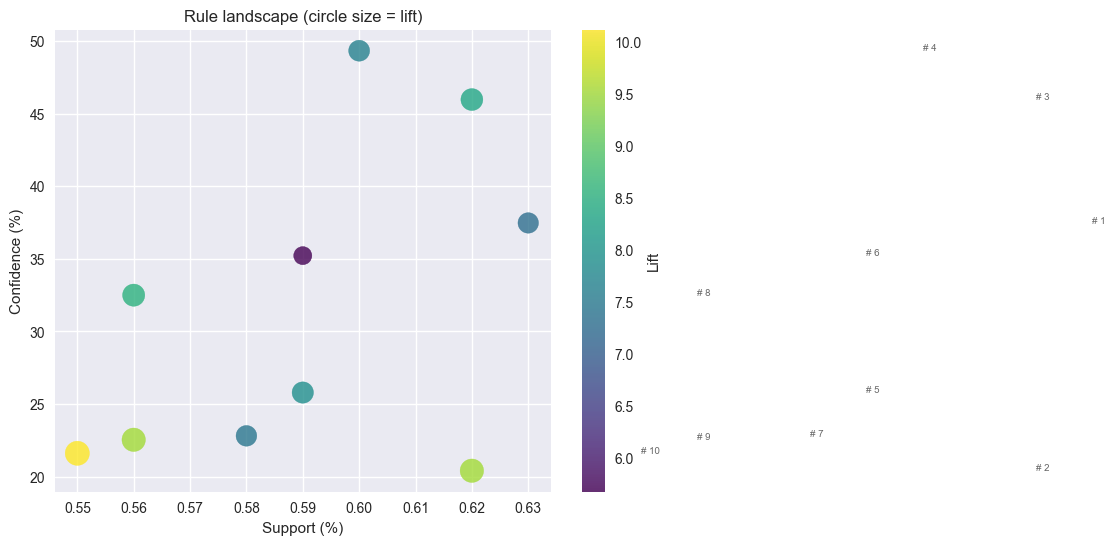

In [9]:
rule_plot_path = OUTPUT_DIR / 'rule_landscape.png'
plot_data = rules.merge(rule_table[['Rule', 'Rank']], left_on='rule_text', right_on='Rule')
plot_data = plot_data.sort_values('Rank').copy()
plot_data['label'] = plot_data['Rank'].apply(lambda x: f'# {x}')
plot_rule_network(
    plot_data,
    output_path=str(rule_plot_path),
    top_k=len(plot_data),
    label_col='label',
)
legend_lines = [f"Rule #{int(row.Rank)} {row.Rule}" for _, row in rule_table.iterrows()]
legend_text = "\n".join(legend_lines)
print('Rule legend\n' + legend_text)

#### Takeaway:

The rule landscape makes the trade-offs easy to see: the breakfast rules (#1–#3) sit on the far right with high support and decent lift, while yogurt + fruit (#8) and pasta-night rules (#6–#7) cluster lower on support but glow with higher lift (circle size/color). Rule #9 (bag snacks + baked goods → soft drinks) spikes in confidence above 60%, signaling a reliable snack mission, and deli lunch (#5) keeps lift above 4. Put simply, breakfast bundles give the broadest reach, pasta and yogurt bundles punch above their weight in incremental attachment, and snack combos deliver remarkable follow-through—together they cover the key missions we want to promote.

## Back to our initial business question: creating recommendation for bundles.

Which high-support product and category bundles within Dunnhumby baskets deserve prioritized co-promotional shelf space and tailored bundles?


- **Breakfast bundle:** Cold cereal almost always co exists with bread and milk, and adding juice or soft drinks keeps the lift above three. We can build a breakfast essentials promo aimed at Premium Loyalists with a follow on offer for occasional shoppers who only buy cereal today.

- **Deli lunch bundle:** Deli meats connect strongly with bag snacks and bakery bread. Co locating these categories or running a sandwich kit coupon will save shoppers time while protecting our lunch share from convenience stores.

- **Pasta night bundle:** Dry pasta brings cheese and milk into the basket, which signals that shoppers are also grabbing sauce ingredients. Featuring pasta, cheese, and salad kits in the same display will grow ring size without pushing families above the twelve item comfort zone.

- **Balanced snacking bundle:** Baked sweet goods paired with soft drinks or bag snacks show high lift alongside good support, so we can target weekend snacking or game day messaging toward these combinations.

- **Healthier snacking bundle:** Yogurt purchases often coincide with tropical fruit and milk, pointing to a lighter snacking routine. A health forward bundle can keep us relevant for shoppers that usually skip indulgent snacks.

## Conclusion

We now have a coherent bundling strategy grounded in real behavior: two years of basket data told us loyalists average only nine unique items per trip, so we kept bundles tight (three core items) to leave room for the rest of the shop. High-support anchors—soft drinks, milk, bakery bread, cheese, snacks—gave us mass-reach entry points, and the Apriori rules spelled out which missions shoppers already follow: breakfast (cereal + bread + milk + beverages), deli lunch (meat + bread + chips), pasta night (dry pasta + cheese + milk), indulgent snacking (baked goods + soft drinks/chips), and lighter snacking (yogurt + fruit + milk). Each delivers meaningful lift without bloating basket size, ensuring every next action ties back to verified shopper behavior.